# Autograd : 자동미분
#### PyTorch로 만든 모든 신경망의 중심에는 autograd 패키지가 존재한다.
Autograd 패키지는 역전파(backprop)를 위해, Tensor의 모든 연산에 대해 미분 값을 자동으로 계산하는 기능을 제공한다. 자동계산을 위해서 사용하는 변수는 torch.autograd에 있는 Variable이다.

#### 역전파(backpropagation)
인공신경망은 입력층, 여러개의 은닉층, 출력층 이렇게 3가지로 구성된다. 각층마다 입력값과 해당하는 가중치를 곱해 다음 단계의 층을 구성해 나간다. 이 과정을 순전파라고 한다. 역전파는 이와 반대되는 과정이다. 출력층에서 입력측 방향으로 값을 계산하면서 기존의 가중치를 업데이트 하는 것이다. 복잡한 함수에 대해 Tensor들마다 각각 편미분을 진행하려면 연산량이 엄청나기 때문에, 합성 함수 미분의 성질을 이용하여 훨씬 적은 연산만으로 각 Tensor들에 대한 미분을 쉽게 구할 수 있다. 또한 역전파를 통해 가중치를 업데이트 한 후, 이에 대해 다시 한 번 순전파를 진행하여 신경망의 오차가 감소하였는지 확인해 볼 수 있다. 

### autograd.Variable
Variable은 autograd 패키지의 핵심 클래스로, Tensor에 정의된 거의 모든 연산을 지원하고, 3가지 속성을 갖는다. 

3가지 속성은 data, grad, grad_fn 이다. data는 Tensor 형태의 데이터를 의미하고, grad는 data가 거쳐온 layer에 대한 미분 값을 의미하고, grad_fn은 미분 값을 계산한 함수에 대한 정보를 의미한다. 

아래는 Autograd 구현에 있어서 중요한 클래스 2개이다.

#### Tensor 클래스
객체의 .requires_grad 속성을 True로 설정하면, 그 tensor에서 이뤄진 모든 연산들을 기록한다. 연산에 대한 계산이 완료된 후, .backward()를 호출하면 자동으로 모든 변화도(gradient)를 계산한다. 이때, Tensor의 변화도는 .grad 속성에 누적된다.

Tensor가 연산에 대해 기록하는 것을 중단하려면, .detach()를 호출하여 연산 기록으로부터 분리(detach)하면 된다.

#### Function 클래스
Variable과 Function 클래스는 서로 연결되어 있으며, 모든 연산 과정을 부호화(encode)하여 비순환 그래프를 생성한다. 각 Variable 객체에 있는 .grad_fn 속성은 해당 Variable 객체를 생성하는 Function 객체를 참조힌다. (예외 상황, Variable을 사용자가 직접 생성한 경우에는 grad_fn이 값은 None이다.)

미분계수를 계산하고 싶으면, Variable 객체의 .backward()를 호출한다. Variable이 스칼라일 경우(한 개의 요소만을 갖는 상황)에는, backward()에 별도 인자를 지정할 필요가 없다. 이와 다르게 여러 요소를 갖는다면, tensor의 크기를 gradient 인수로 지정해야 한다.

#### requires_grad
gradient가 single input이 있을 경우 이것의 output 또한 gradient를 필요로 한다. 반대로, 모든 input에 그래디언트가 필요하지 않은 경우엔 output 또한 필요하지 않다. 모든 변수들이 그래디언트가 필요하지 않다면 backward 연산은 하위 그래프에서 이루어지지 않는다.
gradient값을 사용할 경우'requires_grad = true'로 값을 설정하면되고, gradient 값을 사용하지 않을 경우(ex. pretrain된 CNN을 사용하고 싶을 경우) 고정하는 부분에서 'requires_grad = false'로 바꿔주면 된다.

### *Autograd의 기본 기능
### >Tensor의 requires_grad, is_leaf, grad_fn, grad 실습하기
###### 참고 : https://teamdable.github.io/techblog/PyTorch-Autograd

Code 1

In [3]:
import torch

def get_tensor_info(tensor):
  info = []
  for name in ['requires_grad', 'is_leaf', 'grad_fn', 'grad']:
    info.append(f'{name}({getattr(tensor, name)})')
  info.append(f'tensor({str(tensor)})')
  return ' '.join(info)

x = torch.tensor(5.0)
y = x ** 3
z = torch.log(y)

print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('z', get_tensor_info(z))

x requires_grad(False) is_leaf(True) grad_fn(None) grad(None) tensor(tensor(5.))
y requires_grad(False) is_leaf(True) grad_fn(None) grad(None) tensor(tensor(125.))
z requires_grad(False) is_leaf(True) grad_fn(None) grad(None) tensor(tensor(4.8283))


Code 2

In [7]:
x = torch.tensor(5.0, requires_grad=True)
y = x ** 3
z = torch.log(y)

print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('z', get_tensor_info(z))

z.backward()

print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('z_after_backward', get_tensor_info(z))

x requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(5., requires_grad=True))
y requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F10A708>) grad(None) tensor(tensor(125., grad_fn=<PowBackward0>))
z requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<LogBackward object at 0x000002598F10A748>) grad(None) tensor(tensor(4.8283, grad_fn=<LogBackward>))
x_after_backward requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(0.6000000238418579) tensor(tensor(5., requires_grad=True))
y_after_backward requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F10A748>) grad(None) tensor(tensor(125., grad_fn=<PowBackward0>))
z_after_backward requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<LogBackward object at 0x000002598F10A788>) grad(None) tensor(tensor(4.8283, grad_fn=<LogBackward>))


Code2는 Code1에서 x Tensor를 생성할 때 requires_grad를 True로 설정해 주고, z.backward()를 호출한 것이다.

계산식을 보면 x로부터 y를 계산하고, y로부터 z를 계산한다. z.backward()를 호출하면 계산식을 거꾸로 거슬러 올라간다. z를 z로 편미분한 gradient가 z.grad에 저장되고 z를 y로 편미분한 gradient가 y.grad에 저장되고 z를 x로 편미분한 gradient가 x.grad에 저장된다.

x.requires_grad를 True로 설정하면 x로부터 파생되는 Tensor에는 requires_grad가 True로 자동으로 설정된다. 그래서 x로부터 파생된 y와 z도 requires_grad가 True로 설정된다. 하지만 Gradient를 계산하더라도 그 Gradient를 항상 저장하지는 않는다.
Tensor의 is_leaf가 True이고 requires_grad가 True인 경우에만 Gradient를 계산하고 grad에 Gradient를 저장한다. Tensor의 requires_grad가 사용자에 의해 True로 설정된 경우에 is_leaf가 True로 설정되고, requires_grad가 True로 설정된 Tensor로부터 파생된 Tensor의 경우에는 is_leaf가 False로 설정된다. 그래서 x는 is_leaf가 True이고 y와 z는 is_leaf가 False이다. y와 z의 is_leaf가 False라서, y와 z는 requires_grad가 True라도, y.grad와 z.grad가 z.backward()를 호출한 뒤에도 Gradient가 저장되지 않고 None이 된다.
x.grad를 계산하기 위해서는 y.grad와 z.grad를 계산해서 Chain Rule을 사용해야 되기 때문에 y.grad와 z.grad가 저장이 되지 않더라도 계산은 필요하다. 그래서 y.grad와 z.grad에 Gradient가 저장이 되지 않더라도 y.requires_grad와 z.requires_grad는 True로 설정합니다.

그림으로 다음과 같이 정리할 수 있다.

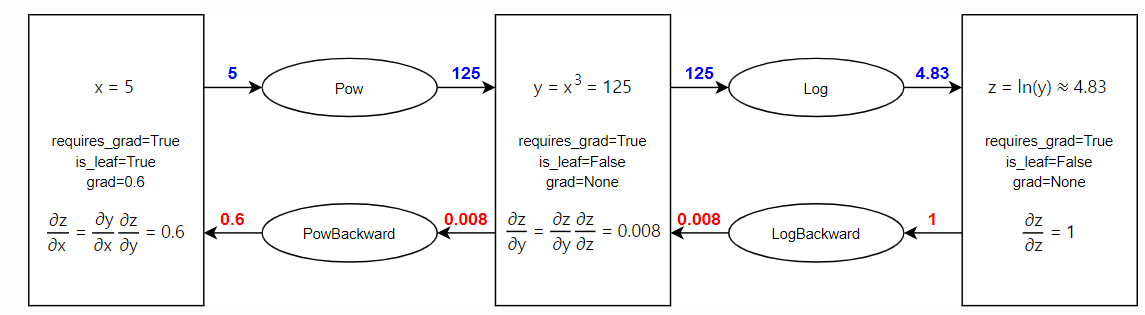

Code 3

In [9]:
x = torch.tensor(5.0, requires_grad=True)
y = x ** 3
z = torch.log(y)

print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('z', get_tensor_info(z))

y.retain_grad()
z.retain_grad()
z.backward()

print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('z_after_backward', get_tensor_info(z))

x requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(5., requires_grad=True))
y requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F113548>) grad(None) tensor(tensor(125., grad_fn=<PowBackward0>))
z requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<LogBackward object at 0x000002598F113648>) grad(None) tensor(tensor(4.8283, grad_fn=<LogBackward>))
x_after_backward requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(0.6000000238418579) tensor(tensor(5., requires_grad=True))
y_after_backward requires_grad(True) is_leaf(False) retains_grad(True) grad_fn(<PowBackward0 object at 0x000002598F113548>) grad(0.00800000037997961) tensor(tensor(125., grad_fn=<PowBackward0>))
z_after_backward requires_grad(True) is_leaf(False) retains_grad(True) grad_fn(<LogBackward object at 0x000002598F113608>) grad(1.0) tensor(tensor(4.8283, grad_fn=<LogBackward>))


Code3은 Code2에서 z.backward()를 호출하게 전에 y.retain_grad()와 z.retain_grad()를 호출한 것이다.

y와 z는 is_leaf가 False라서 y.grad와 z.grad에 Gradient가 저장되지 않는다. 만약 is_leaf를 사용하지 않고 Tensor에 Gradient가 grad에 저장되게 하고 싶으면, 해당 Tensor의 retain_grad()를 호출해서 retains_grad를 True로 설정하고, backward()를 호출하면 grad에 저장된다. 따라서 y.grad에 0.008과 z.grad에 1이 저장된 것을 확인할 수 있다.

Code4

In [10]:
x = torch.tensor(5.0, requires_grad=True)
y = x ** 3
z = torch.log(y)

print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('z', get_tensor_info(z))

z.backward()

print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('z_after_backward', get_tensor_info(z))

z.backward()

x requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(5., requires_grad=True))
y requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F113B48>) grad(None) tensor(tensor(125., grad_fn=<PowBackward0>))
z requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<LogBackward object at 0x000002598F113B88>) grad(None) tensor(tensor(4.8283, grad_fn=<LogBackward>))
x_after_backward requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(0.6000000238418579) tensor(tensor(5., requires_grad=True))
y_after_backward requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F113B88>) grad(None) tensor(tensor(125., grad_fn=<PowBackward0>))
z_after_backward requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<LogBackward object at 0x000002598F113C08>) grad(None) tensor(tensor(4.8283, grad_fn=<LogBackward>))


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

Code4는 Code2에서 z.backward()를 2번 연속으로 호출한 것이다.

backward() 함수는 Graph를 만든 후에 한 번만 호출하는 것을 가정하고 있다. 그래서 backward() 함수를 호출하면 실행 후, backward() 호출에 필요한 각종 자원을 backward() 함수 내부에서 해제한다. 이러한 이유로 backward()를 연속해서 호출하면 Exception이 발생한다.

Code5

In [11]:
x = torch.tensor(5.0, requires_grad=True)
y = x ** 3
z = torch.log(y)

print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('z', get_tensor_info(z))

z.backward(retain_graph=True)

print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('z_after_backward', get_tensor_info(z))

z.backward()

print('x_after_2backward', get_tensor_info(x))
print('y_after_2backward', get_tensor_info(y))
print('z_after_2backward', get_tensor_info(z))

x requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(5., requires_grad=True))
y requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F117C08>) grad(None) tensor(tensor(125., grad_fn=<PowBackward0>))
z requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<LogBackward object at 0x000002598F117C08>) grad(None) tensor(tensor(4.8283, grad_fn=<LogBackward>))
x_after_backward requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(0.6000000238418579) tensor(tensor(5., requires_grad=True))
y_after_backward requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F117DC8>) grad(None) tensor(tensor(125., grad_fn=<PowBackward0>))
z_after_backward requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<LogBackward object at 0x000002598F117DC8>) grad(None) tensor(tensor(4.8283, grad_fn=<LogBackward>))
x_after_2backward requires_grad(True) is_le

Code5는 Code4에서 z.backward(retain_graph=True)를 호출하고 z.backward()를 호출한 것이다.

retain_graph를 True로 설정해서 호출하면 backward() 호출에 필요한 자원을 backward() 내부에서 해제하지 않는다. 그래서 이렇게 backward()를 호출하면 backward()를 한 번 더 호출할 수 있다. 마지막 backward()에서는 retain_graph를 True로 설정하지 않고 backward() 호출했기 때문에 backward() 호출에 필요한 자원을 해제한다. 첫 번째 backward()를 호출한 뒤의 x.grad의 값과 두 번째 backward()를 호출한 뒤의 x.grad의 값을 비교해 보면 값이 다르다. 이것은 backward()에서 Gradient를 x.grad에 저장할 때 Gradient를 덮어쓰는 것이 아니라 기존 저장되어 있는 x.grad값에 Gradient를 더하기 때문이다.

Code6

In [12]:
x = torch.tensor(5.0, requires_grad=True)
y = x ** 3
z = torch.log(y)

print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('z', get_tensor_info(z))

z.backward(retain_graph=True)

print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('z_after_backward', get_tensor_info(z))

x.grad.zero_()
z.backward()

print('x_after_2backward', get_tensor_info(x))
print('y_after_2backward', get_tensor_info(y))
print('z_after_2backward', get_tensor_info(z))

x requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(5., requires_grad=True))
y requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F11C388>) grad(None) tensor(tensor(125., grad_fn=<PowBackward0>))
z requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<LogBackward object at 0x000002598F11C388>) grad(None) tensor(tensor(4.8283, grad_fn=<LogBackward>))
x_after_backward requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(0.6000000238418579) tensor(tensor(5., requires_grad=True))
y_after_backward requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F11C548>) grad(None) tensor(tensor(125., grad_fn=<PowBackward0>))
z_after_backward requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<LogBackward object at 0x000002598F11C548>) grad(None) tensor(tensor(4.8283, grad_fn=<LogBackward>))
x_after_2backward requires_grad(True) is_le

Code6는 Code5에서 z.backward(retain_graph=True)를 호출한 후, 다음 z.backward()를 호출하는 사이에 x.grad를 In-place Operation을 사용해서 0으로 초기화한 것이다.

x.grad를 backward()를 호출하기 전에 초기화를 해 주었기 때문에 첫 번째 backward()를 호출한 후의 x.grad의 값과 두 번째 backward()를 호출한 후의 x.grad의 값이 동일하다.

Code7

In [13]:
x = torch.tensor(5.0, requires_grad=True)
y = x ** 3
w = x ** 2
z = torch.log(y) + torch.sqrt(w)

print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('w', get_tensor_info(w))
print('z', get_tensor_info(z))

z.backward()

print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('w_after_backward', get_tensor_info(w))
print('z_after_backward', get_tensor_info(z))

x requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(5., requires_grad=True))
y requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F11C488>) grad(None) tensor(tensor(125., grad_fn=<PowBackward0>))
w requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F11C488>) grad(None) tensor(tensor(25., grad_fn=<PowBackward0>))
z requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<AddBackward0 object at 0x000002598F11C808>) grad(None) tensor(tensor(9.8283, grad_fn=<AddBackward0>))
x_after_backward requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(1.600000023841858) tensor(tensor(5., requires_grad=True))
y_after_backward requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward0 object at 0x000002598F11C748>) grad(None) tensor(tensor(125., grad_fn=<PowBackward0>))
w_after_backward requires_grad(True) is_leaf(False) retain

Code7은 Code2에서 z를 계산하는 식에 w를 추가한 것이다. w는 x로 계산된다.

각 변수의 관계를 살펴보면, x가 y에 영향을 주고 y가 z에 영향을 준다. 그리고 x가 w에 영향을 주고 w가 z에 영향을 준다. 이런 경우에, x가 변할 때 z가 얼마나 변하는지 구하려면, x가 y를 통해 z에 준 영향과 x가 w를 통해 z에 준 영향을 더해서 다음과 같이 계산해야 한다. 

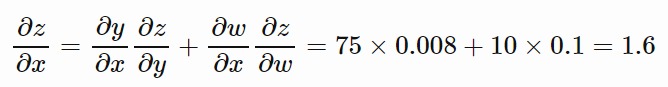

따라서 x.grad에는 1.6이 저장된다. backward()에서 grad에 Gradient를 저장할 때 기존의 grad에 Gradient를 더하기 때문에 이런 계산이 자연스럽게 이루어진다. Convolutional Neural Network의 Convolution Filter처럼 한 Weight가 여러 계산에 Share되면서 계산되는 경우에, 이런 식으로 Gradient가 합산되면서 grad에 저장된다.

Code8

In [14]:
q = torch.tensor(3.0, requires_grad=True)
x = torch.tensor(5.0, requires_grad=True)
y = x ** q
z = torch.log(y)

print('q', get_tensor_info(q))
print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('z', get_tensor_info(z))

z.backward()

print('q_after_backward', get_tensor_info(q))
print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('z_after_backward', get_tensor_info(z))

q requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(3., requires_grad=True))
x requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(5., requires_grad=True))
y requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward1 object at 0x000002598F117388>) grad(None) tensor(tensor(125., grad_fn=<PowBackward1>))
z requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<LogBackward object at 0x000002598F1172C8>) grad(None) tensor(tensor(4.8283, grad_fn=<LogBackward>))
q_after_backward requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(1.6094380617141724) tensor(tensor(3., requires_grad=True))
x_after_backward requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(0.6000000238418579) tensor(tensor(5., requires_grad=True))
y_after_backward requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<PowBackward1 object at 0x000002598F117748>) grad(None) t

Code8은 Code2에서 y를 계산할 때 자승하는 부분을 3대신에 q로 변경하여 q의 Gradient도 계산한다.Gradient를 계산하는 방법은 다음과 같다.

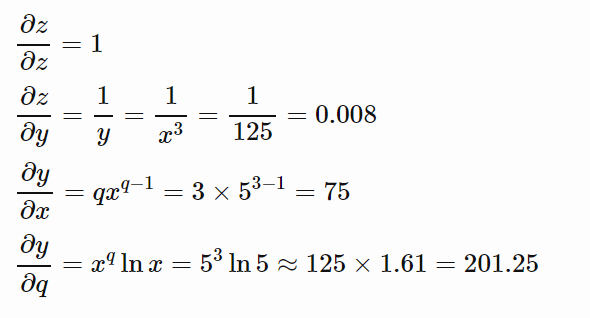

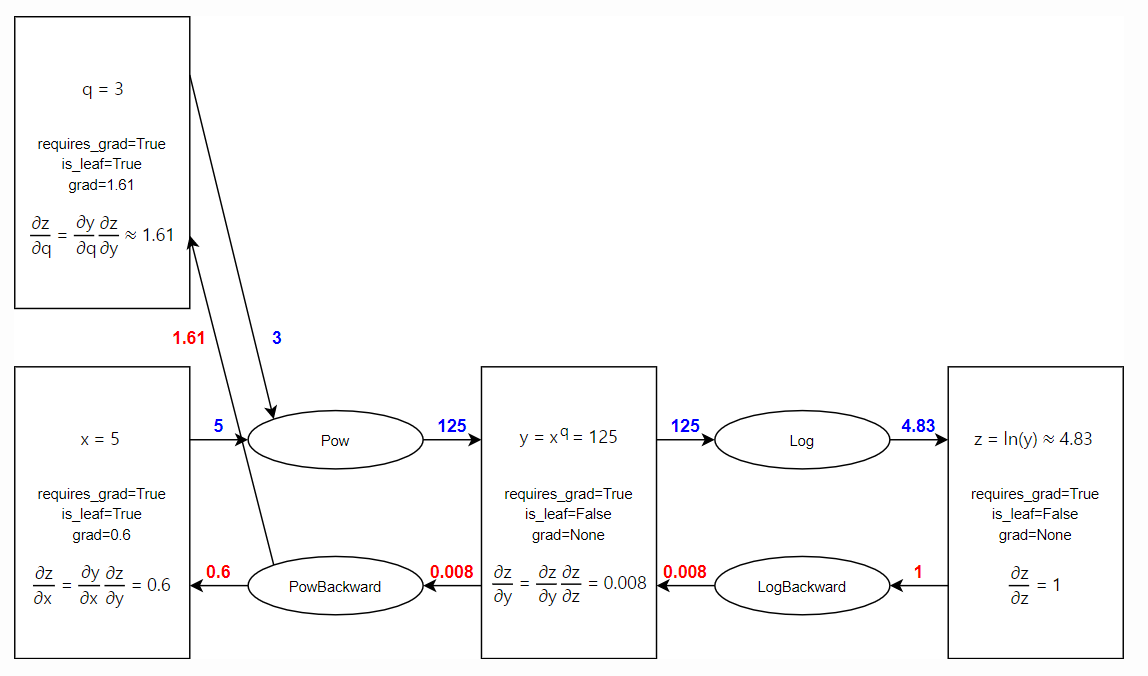

Code9

In [ ]:
class MyPow(torch.autograd.Function):
  @staticmethod
  def forward(ctx, input_1, input_2):
    ctx.save_for_backward(input_1, input_2)
    result = input_1 ** input_2
    return result

  @staticmethod
  def backward(ctx, grad_output):
    input_1, input_2 = ctx.saved_tensors
    grad_input_1 = grad_output * input_2 * input_1 ** (input_2 - 1)
    grad_input_2 = grad_output * input_1 ** input_2 * torch.log(input_1)
    print('input_1', input_1)
    print('input_2', input_2)
    print('grad_output', grad_output)
    print('grad_input_1', grad_input_1)
    print('grad_input_2', grad_input_2)
    return grad_input_1, grad_input_2

myPow = MyPow.apply

q = torch.tensor(3.0, requires_grad=True)
x = torch.tensor(5.0, requires_grad=True)
y = myPow(x, q)
z = torch.log(y)

print('q', get_tensor_info(q))
print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('z', get_tensor_info(z))

z.backward()

print('q_after_backward', get_tensor_info(q))
print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('z_after_backward', get_tensor_info(z))

Code 9은 Code8에서 y를 계산할 때 자승하는 연산자를, PyTorch에서 제공해 주는 연산자 대신에, MyPow에 직접 구현하여 사용한다.

실행결과는 Code 8과 동일하다. 만약에 사용하고자 하는 연산자를 PyTorch에서 제공하지 않는 경우에는 직접 연산자를 구현해서 사용해야 한다. 여기서는 연산자를 어떻게 구현할 수 있는지 알아보기 위해 PyTorch에서 제공하는 연산자를 직접 구현해 보았다. 연산자의 계산과정을(forward) 구현하는 것은 크게 어렵지 않은데 Gradient계산을 위한 부분은(backward)는 조금 신경을 써야 한다.

backward()를 호출하면 기존의 계산식을 거꾸로 거슬러 올라가면서 Gradient를 계산한다. 이때 거슬러 올라가면서 호출해 주는 함수의 정보가 Tensor의 grad_fn에 저장됩니다. 살펴보면 is_leaf가 True라서 거슬러 올라갈 필요가 없는 경우에 grad_fn이 존재하지 않고, is_leaf가 False라서 거슬러 올라갈 필요가 있는 경우에 grad_fn이 존재합니다. Code 8에서 y.grad_fn이 PowBackward1로 되어 있는데, 이것이 어떻게 작동하는지 살펴보기 위해 여기서는 MyPow를 직접 구현하였고, 현재 y.grad_fn이 torch.autograd.function.MyPowBackward로 설정되어 있는 것을 확인할 수 있다.

PyTorch에서 연산자를 정의할 때 torch.autograd.Function를 상속하여 forward()와 backward()를 구현한다. forward()에는 ctx와 연산자에 전달되는 argument들이 차례대로 전달되고 이것을 이용해서 연산자가 계산해야 될 계산을 한 후에 계산결과를 return한다. 여기서 추가로 처리해 줘야 할 것이 있는데, backward()에서 Gradient를 계산하기 위해서는 forward()의 연산 당시의 상태를 알고 있어야 하기 때문에, backward()에서 필요한 상태정보를 forward()에서 ctx.save_for_backward()를 호출하여 저장해 줘야 한다. 여기서 상태란, forward() 당시의 구체적인 변수값을 의미한다. 이를 알아야 Gradient를 구체적인 숫자로 계산할 수 있다. 

Code10

In [15]:
x = torch.tensor(5.0, requires_grad=True)
y = x * torch.tensor([2.0, 3.0, 5.0])
w = y.detach()
z = w @ torch.tensor([4.0, 7.0, 9.0])

print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('w', get_tensor_info(w))
print('z', get_tensor_info(z))

z.backward()

print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('w_after_backward', get_tensor_info(w))
print('z_after_backward', get_tensor_info(z))

x requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(5., requires_grad=True))
y requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<MulBackward0 object at 0x000002598F0A4E48>) grad(None) tensor(tensor([10., 15., 25.], grad_fn=<MulBackward0>))
w requires_grad(False) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor([10., 15., 25.]))
z requires_grad(False) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(370.))


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Code10은 x에서 Broadcast를 이용해서 3개 Element를 가지는 y를 계산하고, y를 이용하여 z를 계산할 때 y.detach()를 호출하고, Dot Product로 Scalar를 가지는 z를 계산한 후 backward()를 호출한 것이다.

requires_grad가 True인 Tensor를 이용하여 계산을 하면 파생된 Tensor들도 require_grad가 True가 된다. 만약에 계산 도중 이것을 의도적으로 끊고 싶으면 (해당 계산을 통해 backward()를 부르지 않을 것이라면) detach()를 호출한다. detach()가 return한 Tensor는 requires_grad가 False로 설정되고 해당 Tensor에서 파생된 Tensor도 requires_grad가 False로 설정된다. 여기서는 w와 z의 requires_grad가 False로 설정된다. 그리고 z.backward()를 호출했을 때 Exception이 발생합니다.

Code11

In [16]:
x = torch.tensor(5.0, requires_grad=True)
y = x * torch.tensor([2.0, 3.0, 5.0])
w = y.detach()
w.requires_grad_()
z = w @ torch.tensor([4.0, 7.0, 9.0])

print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('w', get_tensor_info(w))
print('z', get_tensor_info(z))

z.backward()

print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('w_after_backward', get_tensor_info(w))
print('z_after_backward', get_tensor_info(z))

x requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(5., requires_grad=True))
y requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<MulBackward0 object at 0x000002598F0B72C8>) grad(None) tensor(tensor([10., 15., 25.], grad_fn=<MulBackward0>))
w requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor([10., 15., 25.], requires_grad=True))
z requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<DotBackward object at 0x000002598F0B7248>) grad(None) tensor(tensor(370., grad_fn=<DotBackward>))
x_after_backward requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) grad(None) tensor(tensor(5., requires_grad=True))
y_after_backward requires_grad(True) is_leaf(False) retains_grad(None) grad_fn(<MulBackward0 object at 0x000002598F0B72C8>) grad(None) tensor(tensor([10., 15., 25.], grad_fn=<MulBackward0>))
w_after_backward requires_grad(True) is_leaf(True) retains_grad(None) grad_fn(None) g

Code11은 Code10에서 y.detach()를 호출하면 w의 requires_grad가 False로 설정되는데, w.requires_grad_()를 호출해서 w.requires_grad를 다시 True로 설정한다.

detach()를 호출한 후에 w.requires_grad를 다시 True로 설정해도 w.is_leaf가 True이고 w.grad_fn는 존재하지 않는다. 즉, 기존 그래프 안에 포함되어 있지 않으므로 z.backward()를 호출해도 x.grad는 저장되지 않고 w.grad만 저장된다.

Code12

In [ ]:
x = torch.tensor(5.0, requires_grad=True)
y = x ** 3
z = torch.log(y)

print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('z', get_tensor_info(z))

z.backward()

print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('z_after_backward', get_tensor_info(z))

print('x.grad_after_backward', get_tensor_info(x.grad))
print('y.grad_after_backward', get_tensor_info(y.grad))
print('z.grad_after_backward', get_tensor_info(z.grad))

x_2nd_grad = torch.autograd.grad(x.grad, x)

print('x_2nd_grad', x_2nd_grad)

Code12는 Code2에서 z를 x로 편미분한 것을 x.grad에 저장했었는데, 여기서는 그 뒤에 torch.autograd.grad()를 사용하여 x.grad를 x로 미분해서 z를 x로 2번 편미분하려고 하는 것이다. 

x.grad를 살펴보면 x.grad.requires_grad와 x.grad.grad_fn이 설정되어 있지 않다. 즉, x.grad가 기존 Graph에서 detach된 것처럼 Graph안에 포함되어 있지 않아서, x가 변할 때 x.grad가 얼마나 변하는지(z를 x로 2번 편미분한 값)를 계산할 수가 없다. 그래서 torch.autograd.grad()를 호출할 때 Exception이 발생한다.

Code13

In [ ]:
x = torch.tensor(5.0, requires_grad=True)
y = x ** 3
z = torch.log(y)

print('x', get_tensor_info(x))
print('y', get_tensor_info(y))
print('z', get_tensor_info(z))

z.backward(create_graph=True)

print('x_after_backward', get_tensor_info(x))
print('y_after_backward', get_tensor_info(y))
print('z_after_backward', get_tensor_info(z))

print('x.grad_after_backward', get_tensor_info(x.grad))
print('y.grad_after_backward', get_tensor_info(y.grad))
print('z.grad_after_backward', get_tensor_info(z.grad))

x_2nd_grad = torch.autograd.grad(x.grad, x)

print('x_2nd_grad', x_2nd_grad)

Code13은 Code12에서 z.backward()를 호출한 부분에 z.backward(create_graph=True)를 호출한 것이다.

z.backward()를 호출하는 대신에 z.backward(create_graph=True)로 호출하면 저장되는 x.grad도 Graph에 포함되면서, x.grad.requires_grad가 True로 설정되고 x.grad.grad_fn도 설정된다. 따라서 torch.autograd.grad(x.grad, x)를 호출하면 x가 변할 때 x.grad가 얼마나 변하는지(z를 x로 2번 편미분한 값)를 계산할 수 있다. 또한 z.backward(create_graph=True)를 호출하면 이로 인해 파생되는 계산결과인 y.grad와 z.grad도 Graph에 포함된다.

### *PyTorch Tutorial에 나와 있는 코드 실습

In [1]:
import torch
from torch.autograd import Variable

Variable을 생성한다.

In [2]:
x = Variable(torch.ones(2, 2), requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Variable 연산을 수행한다.

In [3]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


이 때, y는 연산의 결과로 생성된 객체로, grad_fn 속성을 갖는다.

In [4]:
print(y.grad_fn)

y 에 추가 연산을 적용한다.

In [5]:
z = y * y * 3
out = z.mean()

print(z)
print("----"*8)
print(out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
--------------------------------
tensor(27., grad_fn=<MeanBackward0>)


.requires_grad_( ... ) 는 기존 Tensor의 requires_grad 값을 바꿔치기 (in-place)하여 변경한다. 입력값이 지정되지 않으면 기본값은 False 이다.

In [6]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


requires_grad의 값 변화

In [7]:
x = Variable(torch.randn(5, 5))
y = Variable(torch.randn(5, 5))
z = Variable(torch.randn(5, 5), requires_grad=True)
a = x + y
print(a.requires_grad)
b = a + z
print(b.requires_grad)

False
True


역전파를 통해 gradient 계산

In [23]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
y.backward(torch.ones(2, 2), retain_graph=True)
# the retain_variables flag will prevent the internal buffers from being freed
print(x)
print(y)
print(x.grad)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
tensor([[1., 1.],
        [1., 1.]])


In [21]:
z = y * y
print(z)

tensor([[9., 9.],
        [9., 9.]], grad_fn=<MulBackward0>)
